In [1]:
%matplotlib inline
import pandas as pd
import requests
from bs4 import BeautifulSoup

## Attempt 1: Get ADP data from myfantasyleague.com dev site
- +JSON is organized
- +Easily accessed
- -too much info only really need QB, RB, WR, TE, and D/ST

In [2]:
response = requests.get('http://football.myfantasyleague.com/2010/export?TYPE=adp&L=&W=&JSON=1')
data = response.json()
data = data['adp']['player']
adp=pd.DataFrame(data)



In [3]:
response = requests.get('http://football.myfantasyleague.com/2010/export?TYPE=players&L=&W=&JSON=1')
data = response.json()
data = data['players']['player']
players=pd.DataFrame(data)


## Get weekly performance stats starting with 2010
- only has top scorers. scrubs and bye week players do not show up
- easily scraped and cleaned


In [4]:
def get_DF_from_table(season, week, pos):
    url = 'http://www.thehuddle.com/stats/%s/plays_weekly.php?week=%s&pos=%s&col=FPTS&ccs=1' % (season, week, pos)
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    if not soup:
        pass
    data = soup.table
    head = data.thead.find_all('th')[5:]

    headers = []
    for th in head:
        colname = th.a.text.strip()
        headers.append(colname)

    rows = data.tbody.find_all('tr')
    body = []
    for r in rows:
        cells = r.find_all('td')
        cur_row = []
        for c in cells:
            cell = c.text.strip()
            cur_row.append(cell)
        body.append(cur_row)
    df2 = pd.DataFrame(body, columns = headers)
    df2['SEASON'] = season
    df2['WEEK'] = week
    return df2

seasons = ['2010', '2011', '2012', '2013', '2014', '2015']
weeks = ['1','2', '3', '4', '5', '6', '7','8','9','10','11','12','13','14','15','16']
pos = ['QB', 'RB', 'WR','TE']
frames =[]
for s in seasons:
    for w in weeks:
        for p in pos:
            frames.append(get_DF_from_table(s, w, p))
        
result = pd.concat(frames)

print result.shape


(36752, 15)


In [5]:
result = result.reset_index(drop=True)
print result.shape
result.to_csv('ffb_stats.csv')

(36752, 15)


In [6]:
def convert_name_to_lastname_first(name):
    split = name.split(" ")
    converted_name = split[1] +", "+split[0]
    return converted_name
def get_adp(name, season):
    player_adp = adp_df[(adp_df['Fullname'] == name)& (adp_df['Season'] == season)]
    if player_adp.empty:
        return None
    return player_adp.iloc[0]['Avg. Pick']
    


In [7]:
adp_df = pd.read_csv('nfl adp - Sheet7.csv')
adp_df['Fullname'] = adp_df['Lastname'] + " " + adp_df['FirstName']


In [8]:
result['Fullname'] = result['PLAYER'].apply(convert_name_to_lastname_first)

adps = []
i = 0
while i < result.shape[0]:
    adps.append(get_adp(result['Fullname'][i], int(result['SEASON'][i])))
    i = i +1
result["ADP"] = adps
print result.head()

           PLAYER  NFL PLAYS FPTS RUN RYD RTD PASS CMP PYDS PTD FUM INT  \
0  Peyton Manning  IND    57   34   0   0   0   57  40  433   3   0   0   
1      Jay Cutler  CHI    40   29   5  22   0   35  23  372   2   1   1   
2   Carson Palmer  CIN    54   26   4   9   0   50  34  345   2   0   1   
3     Eli Manning  NYG    34   25   4  -2   0   30  20  263   3   0   3   
4       Tom Brady   NE    35   25   0   0   0   35  25  258   3   0   0   

  SEASON WEEK         Fullname    ADP  
0   2010    1  Manning, Peyton  12.27  
1   2010    1      Cutler, Jay  73.34  
2   2010    1   Palmer, Carson  79.79  
3   2010    1     Manning, Eli  81.71  
4   2010    1       Brady, Tom  20.01  


                PLAYER  NFL PLAYS  FPTS RUN  RYD RTD PASS CMP PYDS  PTD FUM  \
13       Aaron Rodgers   GB    36    18   5    9   0   31  19  188    2   0   
18          Drew Brees   NO    40    15   4   -6   0   36  27  237    1   0   
39       Chris Johnson  TEN    31    27  27  142   2    4   4    8    0   0   
52  Maurice Jones-Drew  JAC    26    11  23   98   0    3   3   15    0   0   
53     Adrian Peterson  MIN    22    10  19   87   0    3   3   14    0   0   

   INT SEASON WEEK             Fullname   ADP  
13   2   2010    1       Rodgers, Aaron  7.44  
18   0   2010    1          Brees, Drew  8.70  
39   0   2010    1       Johnson, Chris  1.81  
52   0   2010    1  Jones-Drew, Maurice  4.66  
53   0   2010    1     Peterson, Adrian  2.47  


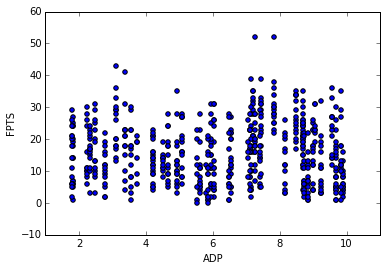

In [10]:
result.FPTS = result.FPTS.astype(int)
result.PTD = result.PTD.astype(int)
result.to_csv('ffb_stats.csv')
stuff = result[result['ADP'] <= 10]
print stuff.head()
stuff.plot(x='ADP', y = 'FPTS', kind='scatter')